# About

- In this notebook I will train Yolo v9 model to detect PPE (Personal Protective Equipment), using [this existing dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow) from [Roboflow](https://universe.roboflow.com/)
- In the [next notebook](https://www.kaggle.com/hinepo/yolov9-inference-for-red-zone-application) I will use this custom model to make inference on videos and post-process the results so they can be used in a Red Zone/Trespassing detection application
- This notebook is a generic training pipeline that you can use to train any Yolo model for object detection task on any dataset (images/number of classes), as long as you provide the dataset in the correct folder structure accepted by Yolo and the annotations/labels in Yolo format
- [Ultralytics - docs](https://docs.ultralytics.com/)
- [Ultralytics - github](https://github.com/ultralytics/ultralytics)

___

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

**<font color='orange'>If you like this notebook, don't forget to show your support with your upvote!</font>**

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6565a6da-f5bd-059c-577e-fd57d54d4bbe)
GPU 1: Tesla T4 (UUID: GPU-eaa30b74-6f45-9665-2d4e-78f2c436a158)


# Installs/Imports

In [ ]:
%%time

!pip install ultralytics==8.1.29


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 3.4 MB/s eta 0:00:00
CPU times: user 226 ms, sys: 44.1 ms, total: 270 ms
Wall time: 14.6 s


In [ ]:
import ultralytics
print(ultralytics.__version__)

8.1.29


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [ ]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [ ]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



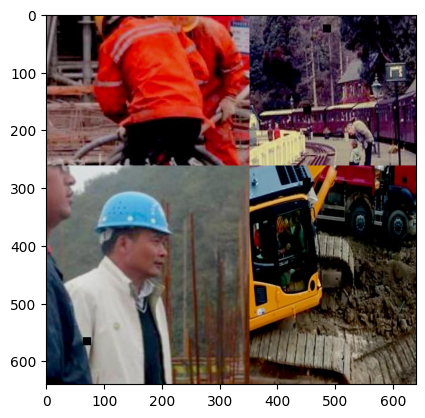

In [ ]:
example_image_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

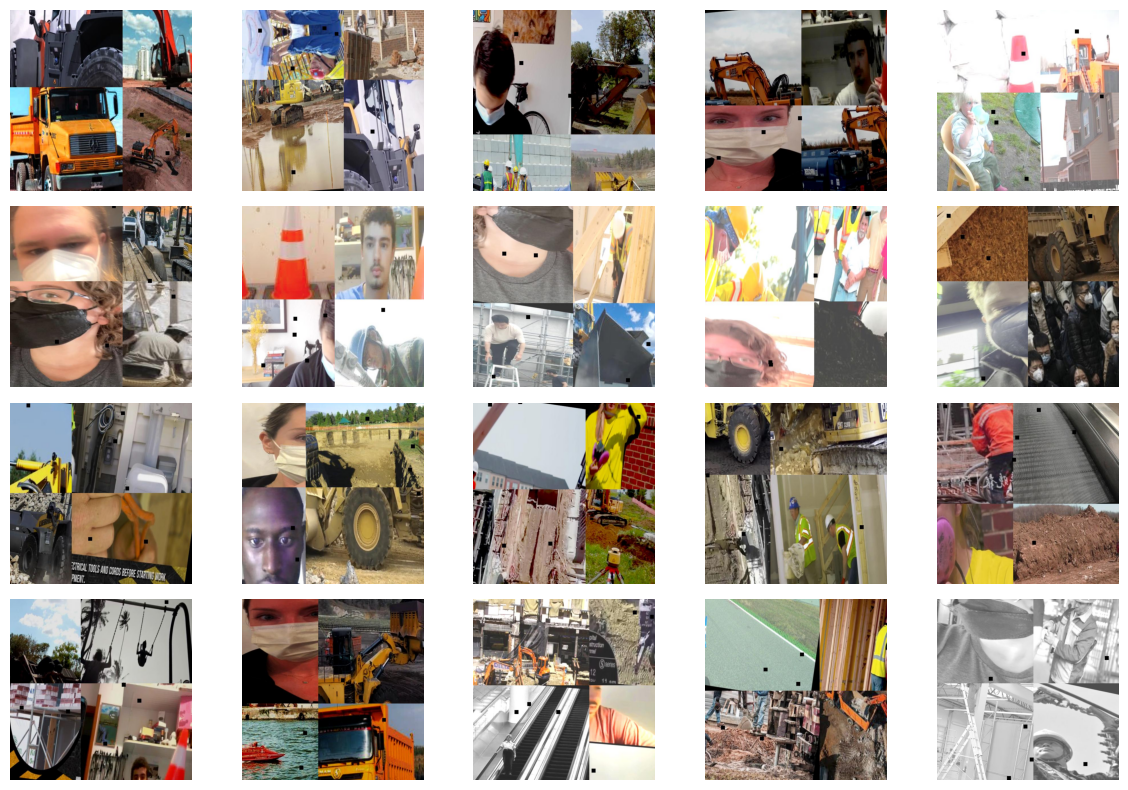

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [ ]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 217 ms, sys: 233 ms, total: 450 ms
Wall time: 10.1 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


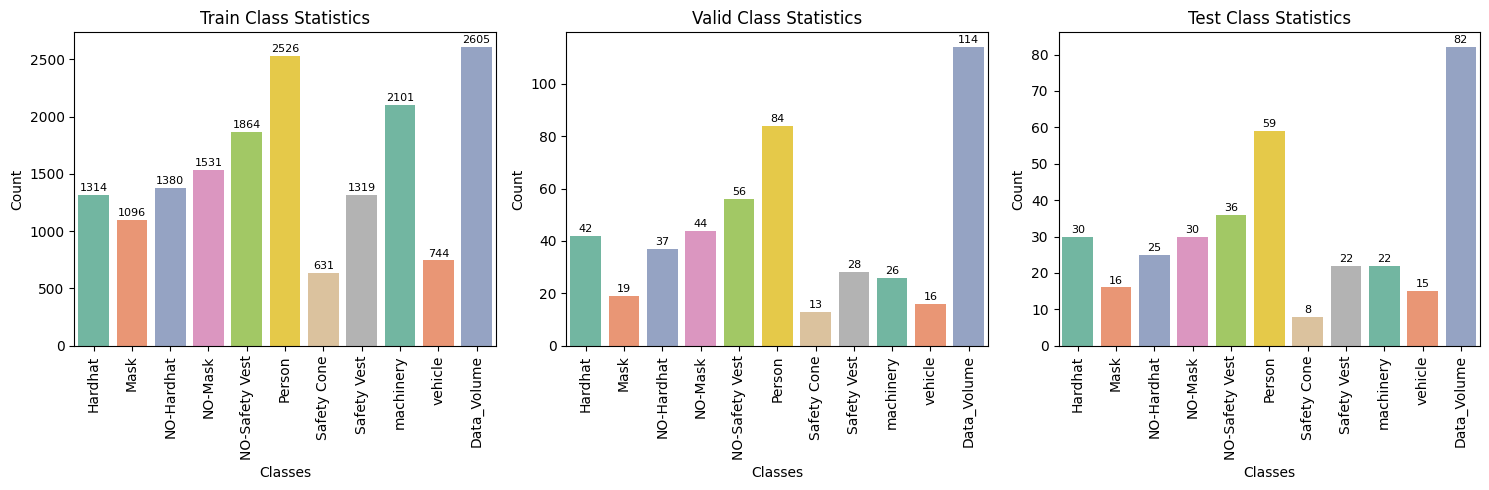

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 465 ms, sys: 322 ms, total: 787 ms
Wall time: 15.1 s


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0,1], # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:01<00:00, 115MB/s] 



image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 90.6ms
Speed: 4.7ms preprocess, 90.6ms inference, 207.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



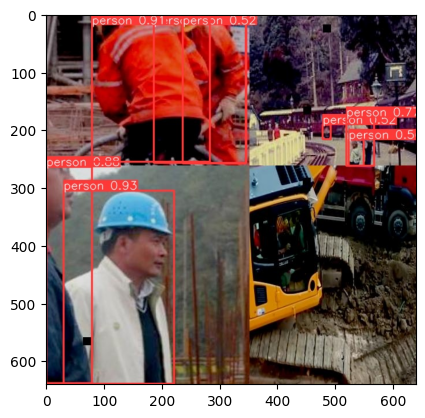

In [ ]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/kaggle/working/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  16


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0,1], # 0
    verbose = False,
)

New https://pypi.org/project/ultralytics/8.2.71 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  ultralytics.nn.modules.block.Silence         []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytic

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov9e_ppe_css_70_epochs', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=10
Transferred 1805/1811 items from pretrained weights
Freezing layer 'model.42.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 75.9MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:02<00:00, 982.28it/s]


train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 688.62it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 1051 images, 1 backgrounds, 0 corrupt:  40%|████      | 1051/2605 [00:01<00:01, 819.46it/s]

Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:02<00:00, 893.83it/s] 
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      12.4G      1.275      1.844      1.519         68        640: 100%|██████████| 163/163 [02:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


                   all        114        697      0.446      0.224      0.229      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70        13G      1.307      1.696      1.535        269        640: 100%|██████████| 163/163 [02:21<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


                   all        114        697      0.489      0.404      0.363      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70        13G      1.314      1.691      1.548        175        640: 100%|██████████| 163/163 [02:18<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


                   all        114        697      0.672      0.396       0.44      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70        13G      1.275      1.605      1.508        154        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


                   all        114        697       0.55      0.438      0.445      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70        13G      1.223      1.506      1.481        231        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697       0.72      0.534      0.573      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70        13G      1.175      1.419      1.448         81        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


                   all        114        697      0.626       0.52      0.555      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70        13G      1.181      1.346      1.426        260        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


                   all        114        697       0.66      0.579      0.581      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70        13G      1.136      1.281      1.407        101        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697       0.77      0.597      0.644      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70        13G      1.126      1.217      1.384        256        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.742      0.581      0.651      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70        13G      1.099      1.181      1.376        175        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697       0.82      0.596      0.677      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      12.4G      1.053      1.116      1.355        104        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.749      0.622       0.68      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70        13G      1.069      1.092      1.356        223        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.805      0.602      0.684      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70        13G      1.038      1.053      1.331        124        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.827      0.645      0.708      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70        13G      1.035      1.017       1.32        151        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.771      0.633       0.67       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70        13G      1.001     0.9859        1.3         95        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.808      0.635      0.704      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70        13G     0.9985     0.9561      1.304        122        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.825      0.647      0.727      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70        13G     0.9767     0.9324      1.288        141        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.805      0.659      0.722      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70        13G     0.9631     0.9089      1.271        248        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.832      0.671      0.739      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70        13G      0.949     0.8804      1.265        123        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.884      0.666      0.761      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70        13G     0.9366     0.8532      1.252        104        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.837      0.684      0.751      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70        13G     0.9223     0.8473      1.248         96        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.895      0.678      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70        13G     0.9155     0.8415      1.244        161        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.848      0.693      0.755      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70        13G     0.8968     0.8164      1.243        111        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.875      0.679      0.758      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70        13G     0.8752     0.7747      1.215        103        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.874      0.706      0.776      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70        13G     0.8807     0.7741      1.214        181        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.886      0.715      0.783      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70        13G     0.8701     0.7432      1.204        136        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.874      0.716      0.789      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70        13G     0.8608     0.7444      1.197        138        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.861      0.723      0.791      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70        13G     0.8616     0.7306      1.199        185        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.893      0.696      0.793      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70        13G     0.8456     0.7038      1.185        146        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697       0.89      0.713      0.797      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70        13G     0.8391     0.7021      1.181        266        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.891       0.72      0.805      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70        13G     0.8221     0.6851      1.168        105        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.909      0.708      0.805      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70        13G      0.824      0.699      1.176        178        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697       0.88      0.745      0.811      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70        13G     0.8033     0.6631      1.168        107        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.856      0.754      0.809      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70        13G       0.79     0.6479      1.142        111        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.876      0.742      0.815      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70        13G     0.7993     0.6349      1.154        198        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.902      0.734      0.813       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70        13G     0.7832     0.6382      1.144        157        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.874       0.75      0.811      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70        13G     0.7755     0.6426      1.152        183        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.935       0.75      0.831      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70        13G     0.7611     0.5982      1.132        156        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.893      0.757      0.824      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70        13G     0.7656     0.6054      1.133        163        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.909      0.762      0.821      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70        13G     0.7548     0.5995      1.129        107        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.917      0.736      0.827      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70        13G     0.7396     0.5867      1.114        119        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.898      0.759      0.837      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70        13G      0.725     0.5733      1.111        111        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.869      0.776      0.828      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70        13G     0.7234     0.5697      1.109        151        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.915      0.762      0.841      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70        13G     0.7084     0.5459      1.096        102        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.905      0.782      0.842       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70        13G     0.7023     0.5505      1.099        203        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.879       0.77      0.838      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70        13G      0.694     0.5375      1.092        135        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.926      0.751      0.842      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70        13G     0.6926     0.5333      1.086        148        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.929      0.774      0.851      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70        13G     0.6797     0.5208      1.082        221        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.875      0.783      0.837       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70        13G     0.6859     0.5202      1.078        128        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.903       0.78      0.849      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70        13G     0.6817     0.5126      1.074        229        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.918      0.759      0.837      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70        13G     0.6675     0.5089      1.072        105        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.895      0.782      0.839      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70        13G     0.6627     0.4995      1.069        189        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.925      0.768      0.845      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70        13G     0.6512     0.4856      1.063        196        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.886      0.801      0.852       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70        13G      0.652     0.4881      1.059        180        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.944      0.778      0.852      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70        13G     0.6338     0.4766      1.049        164        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.907      0.795      0.857        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70        13G      0.631     0.4704      1.053        178        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.913      0.787      0.861      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70        13G     0.6268     0.4602      1.035        143        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.937      0.783       0.86      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70        13G     0.6193     0.4604      1.033        117        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.928      0.796      0.857      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70        13G      0.614     0.4492      1.032        134        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.903      0.805       0.86      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70        13G     0.6009     0.4423       1.02         91        640: 100%|██████████| 163/163 [02:18<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.924      0.805      0.864       0.61
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70        13G      0.592     0.3686      1.011         82        640: 100%|██████████| 163/163 [02:17<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697       0.92      0.792      0.856      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70        13G     0.5819     0.3646      1.007         88        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.897      0.812      0.867      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70        13G     0.5654      0.357     0.9985        113        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.916      0.804      0.871      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70        13G     0.5682     0.3571      1.003        110        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.946      0.793      0.868      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70        13G     0.5538     0.3447       0.99        110        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.938      0.808      0.869      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70        13G     0.5468     0.3357     0.9848         69        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.916      0.816       0.87      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70        13G     0.5336     0.3318     0.9722         61        640: 100%|██████████| 163/163 [02:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        114        697      0.921      0.818      0.866       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70        13G     0.5329     0.3294     0.9703         91        640: 100%|██████████| 163/163 [02:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.914      0.817      0.869      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      12.3G     0.5214     0.3227      0.968         62        640: 100%|██████████| 163/163 [02:17<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


                   all        114        697      0.923      0.818      0.868      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70        13G     0.5183     0.3214     0.9704         71        640: 100%|██████████| 163/163 [02:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


                   all        114        697      0.921      0.816       0.87      0.629

70 epochs completed in 2.916 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


                   all        114        697      0.918      0.817      0.866       0.63
Speed: 1.3ms preprocess, 31.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs
CPU times: user 29.6 s, sys: 8.38 s, total: 38 s
Wall time: 2h 56min 7s


# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv9 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.8 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 8.8s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (10.4s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=640  
Validate

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

# Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


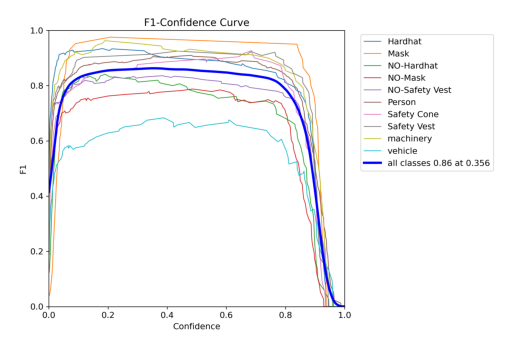



./runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


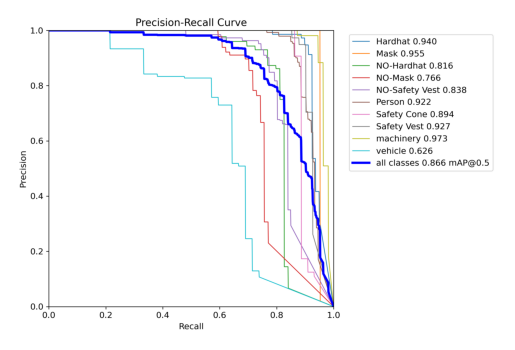



./runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


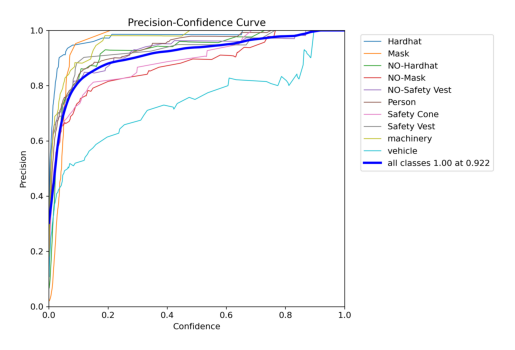



./runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


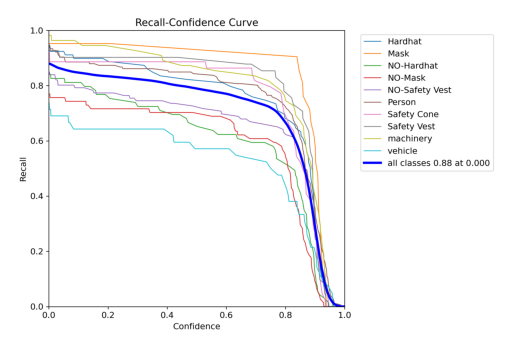



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


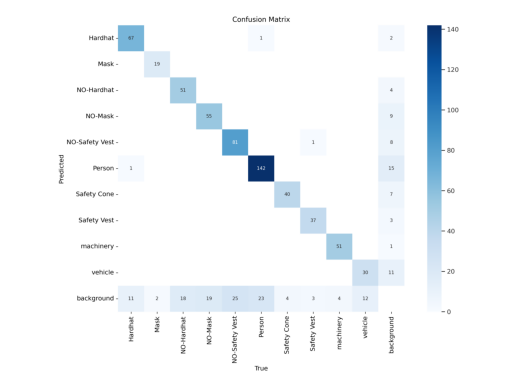



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


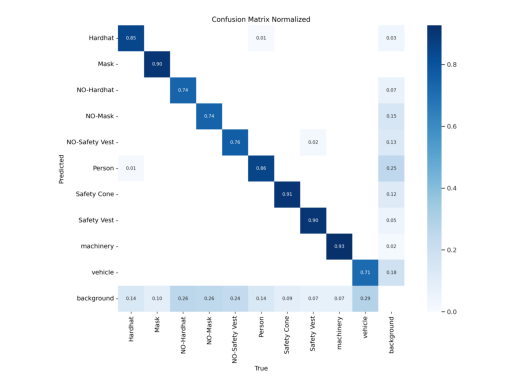



./runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


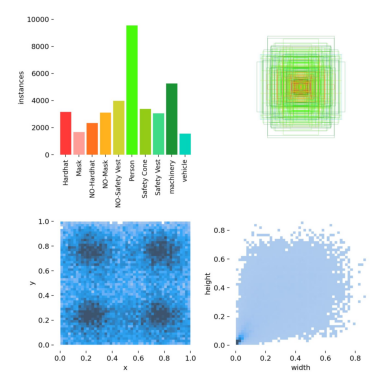



./runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


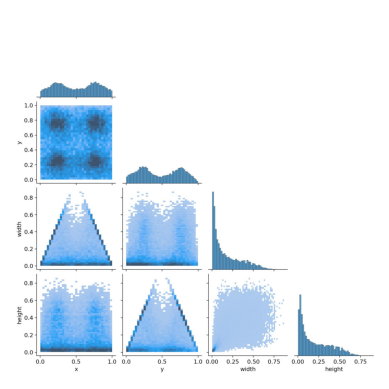



./runs/detect/yolov9e_ppe_css_70_epochs/results.png


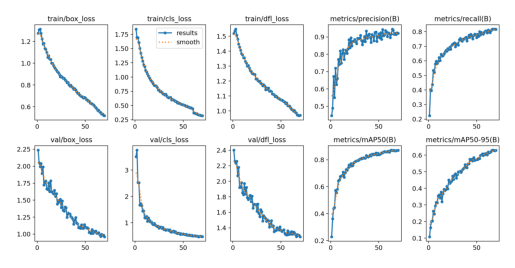

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.27460,1.84380,1.51850,0.44573,0.22372,0.22875,0.10850,2.23760,3.50650,2.4023,0.000237,0.000237,0.000237
1,2,1.30750,1.69610,1.53480,0.48875,0.40371,0.36273,0.16341,2.05090,3.75580,2.2591,0.000468,0.000468,0.000468
2,3,1.31360,1.69140,1.54840,0.67232,0.39623,0.43962,0.20107,1.99300,2.52470,2.2404,0.000692,0.000692,0.000692
3,4,1.27450,1.60540,1.50770,0.55042,0.43807,0.44475,0.20380,2.03800,2.51720,2.2575,0.000684,0.000684,0.000684
4,5,1.22310,1.50570,1.48080,0.72044,0.53387,0.57312,0.26250,1.89370,1.67390,2.0702,0.000684,0.000684,0.000684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.54678,0.33565,0.98484,0.91587,0.81627,0.87036,0.62901,0.96663,0.46899,1.2862,0.000068,0.000068,0.000068
66,67,0.53357,0.33176,0.97221,0.92115,0.81828,0.86587,0.63035,0.99597,0.48344,1.3139,0.000058,0.000058,0.000058
67,68,0.53291,0.32945,0.97029,0.91385,0.81737,0.86857,0.62851,0.98273,0.49080,1.3067,0.000048,0.000048,0.000048
68,69,0.52144,0.32275,0.96796,0.92338,0.81762,0.86831,0.62715,0.98335,0.48079,1.3033,0.000037,0.000037,0.000037


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.51826 , on epoch:  70 


Best Validation Box loss:  0.9608 , on epoch:  70 


Best Training Cls loss:  0.32143 , on epoch:  70 


Best Validation Cls loss:  0.46899 , on epoch:  66 


Best Training DFL loss:  0.96796 , on epoch:  69 


Best Validation DFL loss:  1.2852 , on epoch:  70 



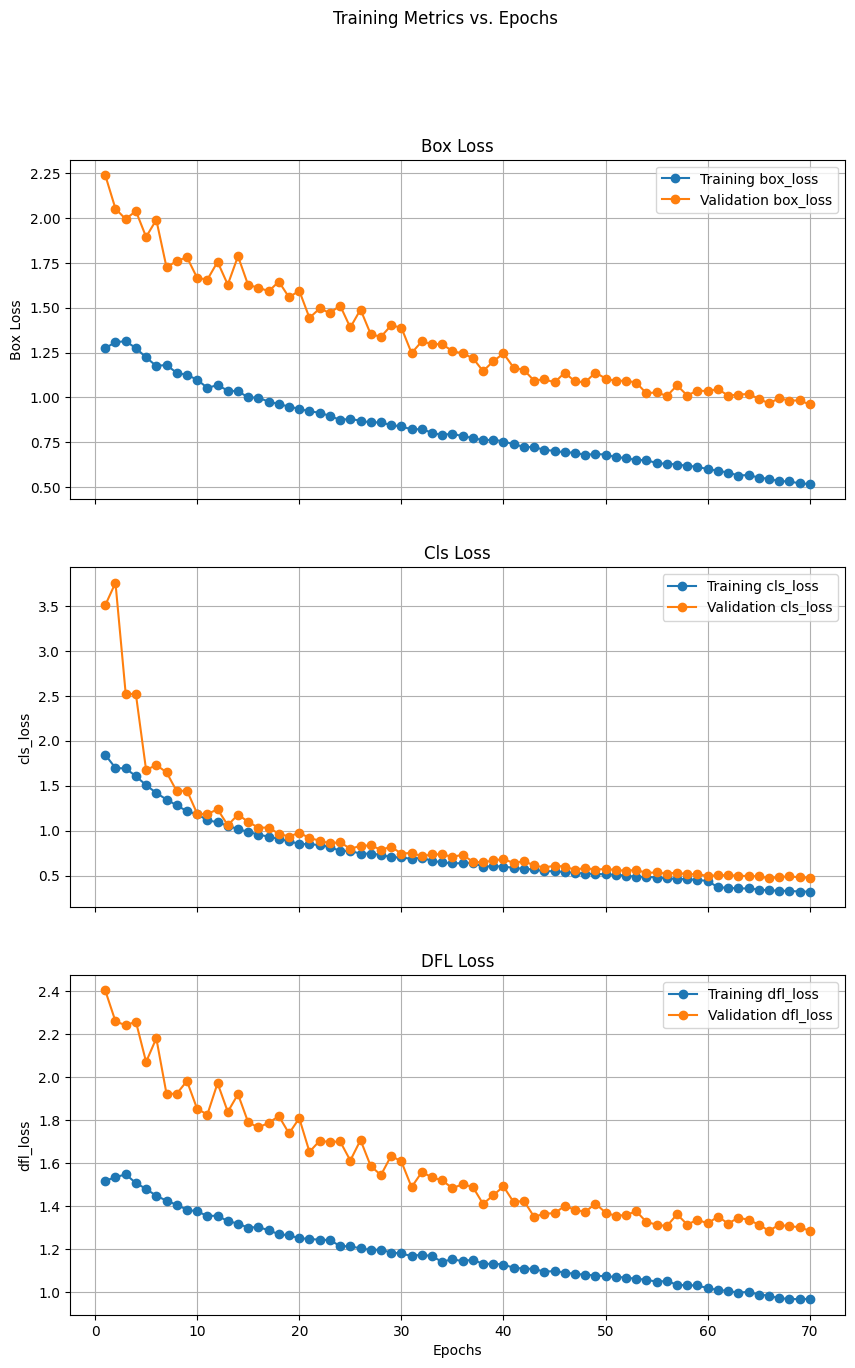

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_labels.jpg


./runs/detect/yolov9e_ppe_css_70_epochs/val_batch2_pred.jpg


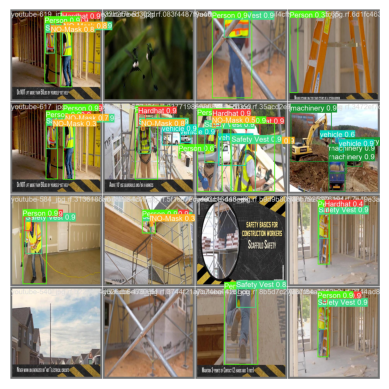

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

# Conclusions

- So now the model is trained and we have customized Yolo to detect PPE.
- In my [next notebook](https://www.kaggle.com/hinepo/yolov9-inference-for-red-zone-application) I will use this model to make inference on a video, and combine the PPE detection with a Red Zone application.
- **<font color='orange'>Upvote if you liked it!</font>**